In [2]:
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
import matplotlib.pyplot as plt
import matplotlib as mpl
import pathlib
import shutil
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight 
import pandas as pd

In [3]:
def plot_categories(training_images, training_labels,mapping = None, count = 10):
  fig, axes = plt.subplots(int(np.sqrt(count))+1, int(np.sqrt(count))+1, figsize=(16, 15))
  axes = axes.flatten()
    
  for ax in axes:
    ax.set_axis_off()

  for k in range(count):
    img = training_images[k]
    img = array_to_img(img)
    ax = axes[k]
    ax.set_axis_on()
    ax.imshow(img, cmap="Greys_r")
    label = None
    if mapping:
        label = mapping[training_labels[k]]
    else:
        label = training_labels[k]
        
    ax.set_title(label)
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

In [4]:

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();
    
    
    
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-tumor detected (True Negatives): ', cm[0][0])
  print('Non-tumor incorrectly detected (False Positives): ', cm[0][1])
  print('Tumor missed (False Negatives): ', cm[1][0])
  print('Tumor detected (True Positives): ', cm[1][1])
  print('Total case: ', np.sum(cm[1]))

In [5]:
data_path = pathlib.Path("dataport-dataset/")
data_path = os.path.join(data_path, os.listdir(data_path)[0])

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     zoom_range=0.05,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     brightness_range = [0.5, 1.4],
                                     validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory=data_path,
                                                    batch_size=10,
                                                    target_size=(224, 224),
                                                    shuffle = True,
                                                    class_mode = "binary",
                                                    subset = "training")

validation_generator = train_datagen.flow_from_directory(directory=data_path,
                                                            batch_size=10,
                                                            target_size=(224, 224),
                                                            shuffle = False,
                                                            class_mode = "binary",
                                                            subset = "validation")

Found 425 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


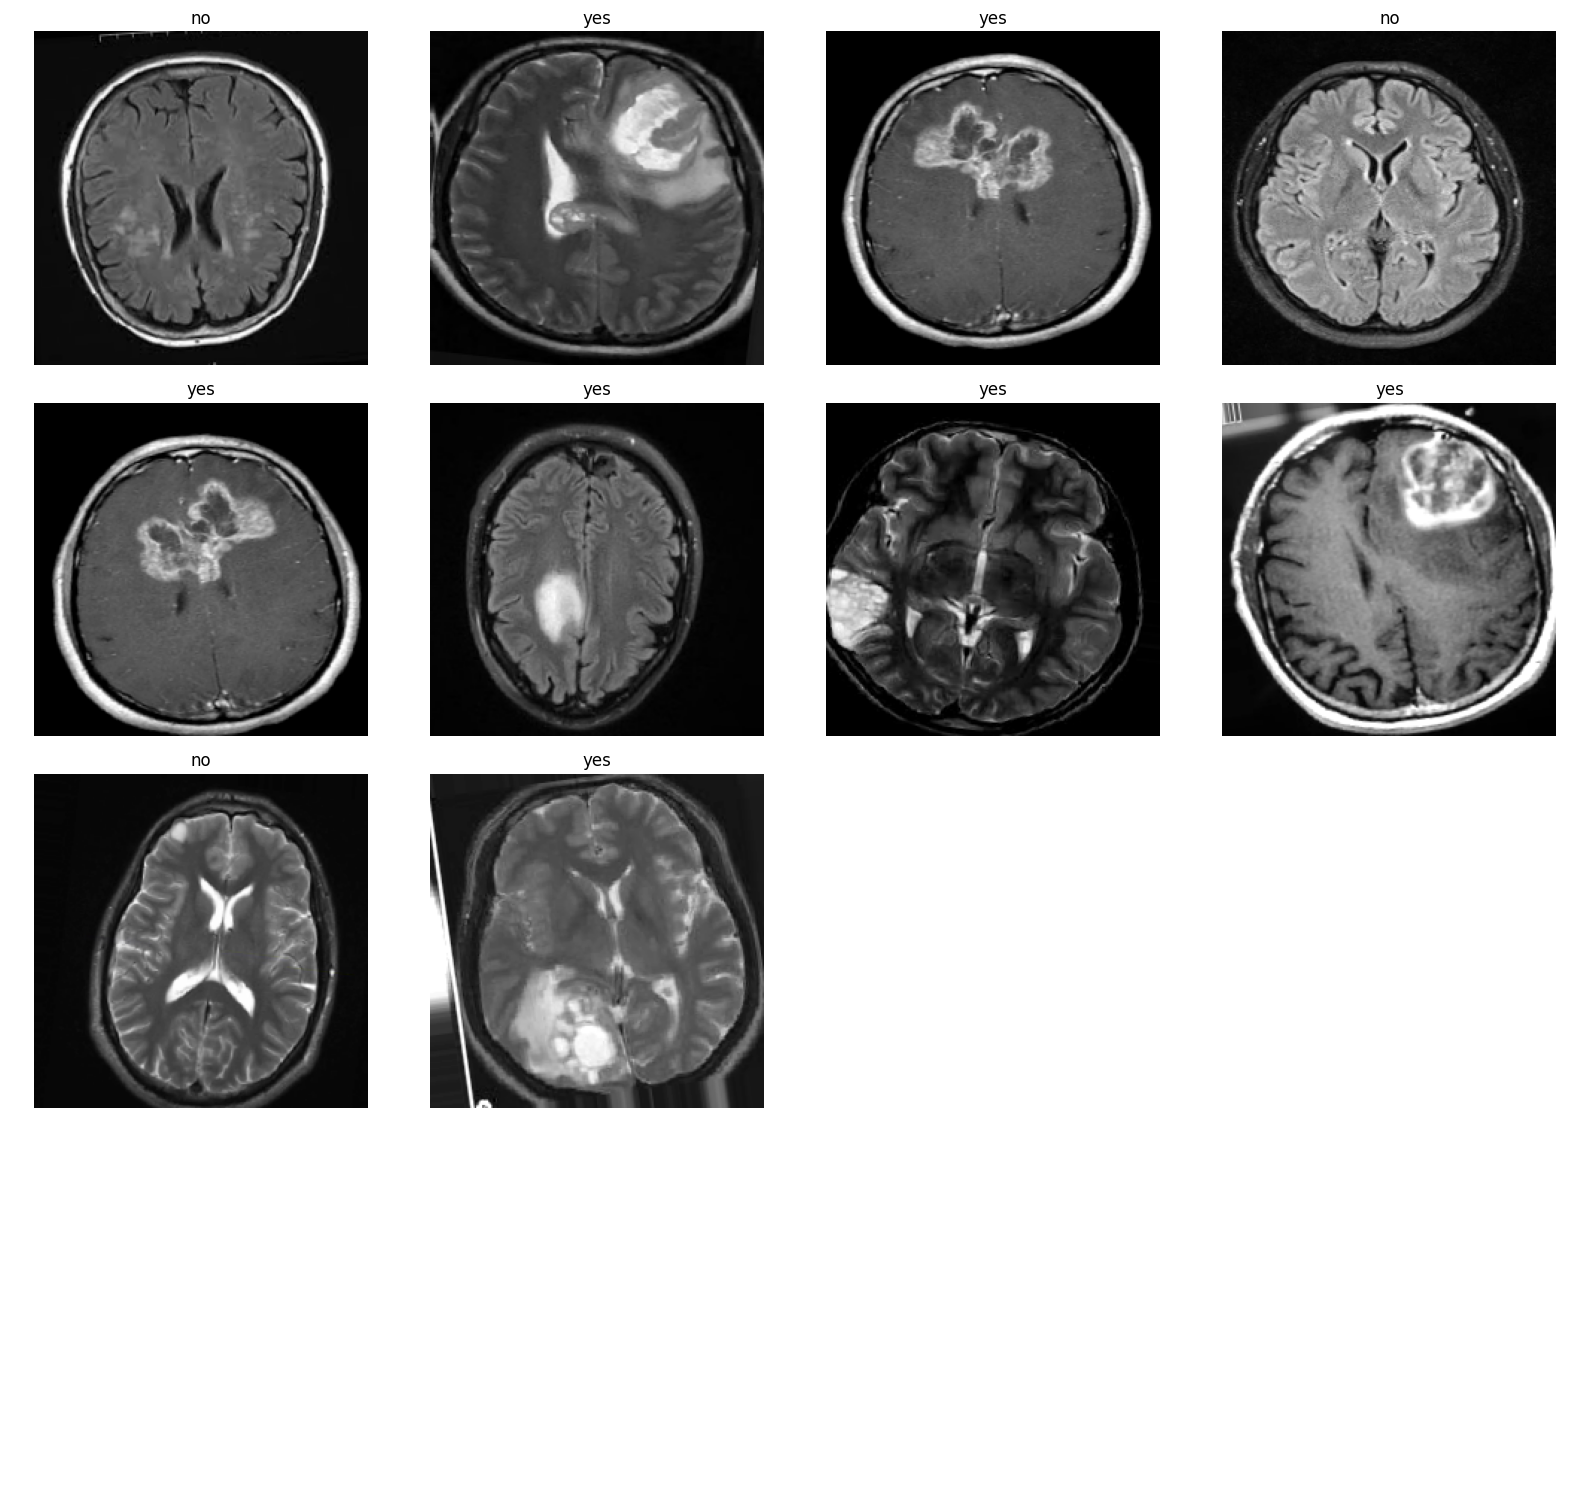

In [7]:
sample_X, sample_y = next(train_generator)
mapping = {1: "yes", 0: "no"}

plot_categories(sample_X, sample_y, mapping, sample_X.shape[0])


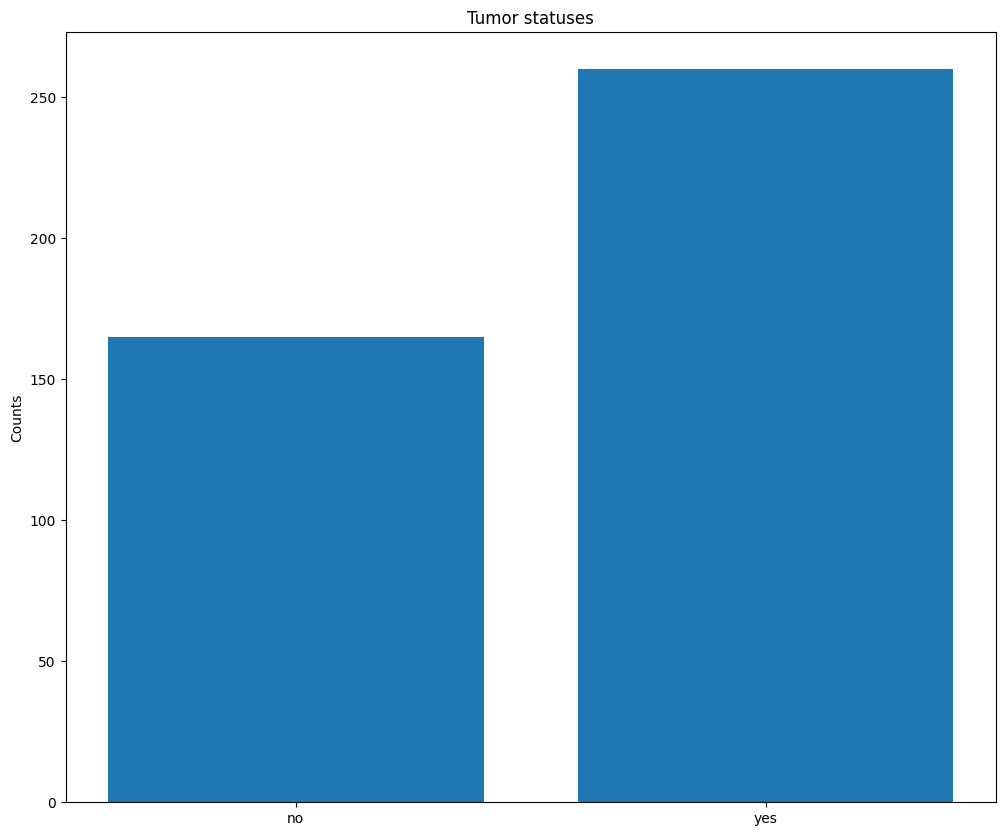

In [8]:
labels, counts = np.unique(train_generator.labels, return_counts = True)
labels = [mapping[l] for l in labels]

fig, ax = plt.subplots()
ax.set_ylabel('Counts')
ax.set_title('Tumor statuses')
ax.bar(labels, counts)

plt.show()

In [9]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
train_class_weights = dict(enumerate(class_weights))


In [10]:
metrics = [
    tf.keras.metrics.TruePositives(name='tp'),tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),
]

# SIMPLE LENET CNN MODEL

In [11]:
model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(filters = 64 , kernel_size = (3,3), activation="relu", input_shape=(224,224,3)),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3), activation="relu"),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3), activation="relu"),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units = 512 , activation="relu"),
      tf.keras.layers.Dropout(rate = 0.5),
      tf.keras.layers.Dense(units = 1 , activation="sigmoid")
  ])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0008),
                loss = "binary_crossentropy",
                metrics=metrics)

tf.keras.utils.plot_model(model) # image of models structure you can get from output folder
model.summary()

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       803,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833,345 (3.18 MB)

 Trainable params: 833,345 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history1 = model.fit(train_generator,epochs = 20, validation_data = validation_generator, class_weight=train_class_weights)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - accuracy: 0.6051 - auc: 0.6428 - fn: 54.5227 - fp: 29.6136 - loss: 0.6747 - prc: 0.7338 - precision: 0.7180 - recall: 0.6069 - tn: 57.0909 - tp: 82.5227 - val_accuracy: 0.7358 - val_auc: 0.7467 - val_fn: 10.0000 - val_fp: 18.0000 - val_loss: 0.5665 - val_prc: 0.7974 - val_precision: 0.7534 - val_recall: 0.8462 - val_tn: 23.0000 - val_tp: 55.0000
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.7605 - auc: 0.8301 - fn: 32.8636 - fp: 21.2045 - loss: 0.5295 - prc: 0.8516 - precision: 0.8291 - recall: 0.7565 - tn: 68.3409 - tp: 100.7727 - val_accuracy: 0.7453 - val_auc: 0.7640 - val_fn: 4.0000 - val_fp: 23.0000 - val_loss: 0.5522 - val_prc: 0.8092 - val_precision: 0.7262 - val_recall: 0.9385 - val_tn: 18.0000 - val_tp: 61.0000
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.7713 - auc: 0.8052 - fn: 28.5455 - fp: 24.8636 - loss: 0.5565 - prc: 0.8405 - precision: 0.8093 - recall: 0.8052 - tn: 64.1364 

In [14]:
validation_results = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results):
  print(name, ': ', value)

loss :  0.4261561632156372
compile_metrics :  58.0


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Non-tumor detected (True Negatives):  26
Non-tumor incorrectly detected (False Positives):  15
Tumor missed (False Negatives):  8
Tumor detected (True Positives):  57
Total case:  65


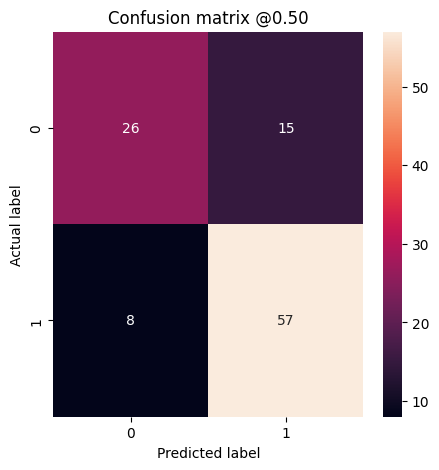

In [15]:
validation_predictions = model.predict(validation_generator)

labels = validation_generator.labels

plot_cm(labels, validation_predictions)

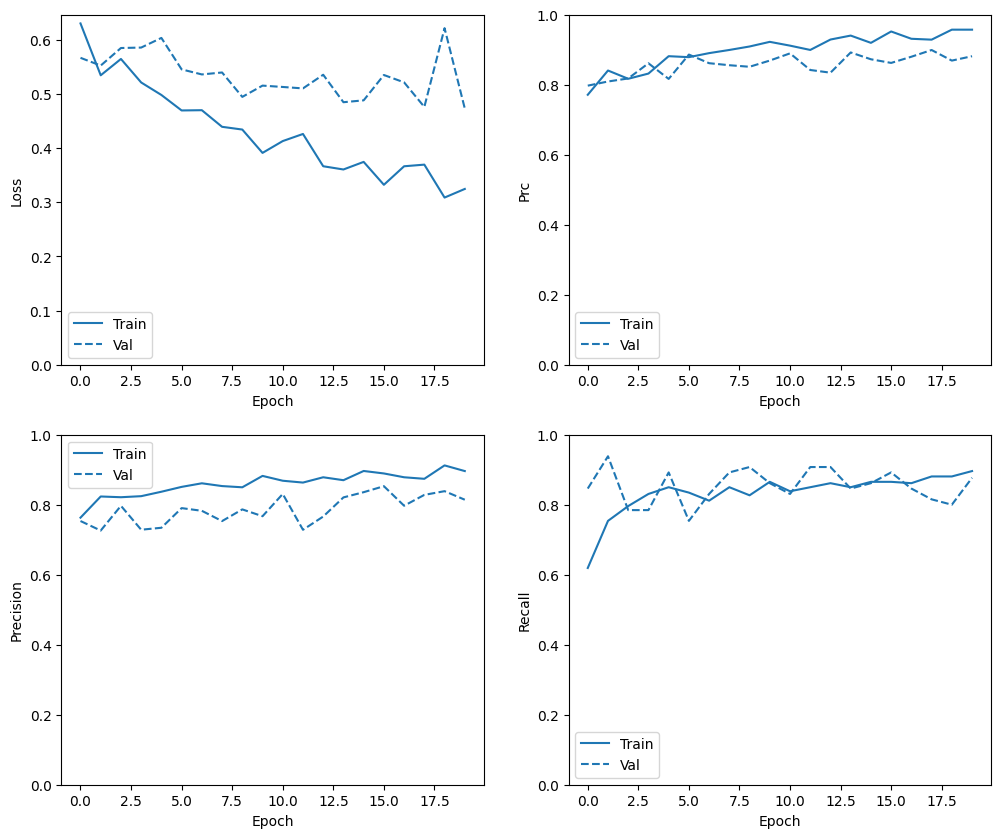

In [16]:
plot_metrics(history1)

# RESNETV2 MODEL

In [17]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(128, activation = 'relu'),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics=metrics)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,915,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,252,193 (226.03 MB)

 Trainable params: 4,915,457 (18.75 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [18]:
history3 = model.fit(train_generator,epochs = 10, validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7639 - auc: 0.8046 - fn: 42.7045 - fp: 33.0455 - loss: 0.9375 - prc: 0.8347 - precision: 0.8227 - recall: 0.7885 - tn: 91.8182 - tp: 160.1364 - val_accuracy: 0.8585 - val_auc: 0.8976 - val_fn: 7.0000 - val_fp: 8.0000 - val_loss: 0.3984 - val_prc: 0.9226 - val_precision: 0.8788 - val_recall: 0.8923 - val_tn: 33.0000 - val_tp: 58.0000
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8141 - auc: 0.8956 - fn: 24.7955 - fp: 16.7500 - loss: 0.4690 - prc: 0.9135 - precision: 0.8674 - recall: 0.8160 - tn: 69.3182 - tp: 111.4091 - val_accuracy: 0.8585 - val_auc: 0.9143 - val_fn: 5.0000 - val_fp: 10.0000 - val_loss: 0.3797 - val_prc: 0.9372 - val_precision: 0.8571 - val_recall: 0.9231 - val_tn: 31.0000 - val_tp: 60.0000
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9093 - auc: 0.9617 - fn: 12.4773 - fp: 9.4773 - loss: 0.2561 - prc: 0.9679 - precision: 0.9257 - recall: 0.9224 - tn: 79.0682 - tp: 120.1

In [19]:
validation_results = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results):
  print(name, ': ', value)

loss :  0.3503808081150055
compile_metrics :  58.0


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step 
Non-tumor detected (True Negatives):  35
Non-tumor incorrectly detected (False Positives):  6
Tumor missed (False Negatives):  4
Tumor detected (True Positives):  61
Total case:  65


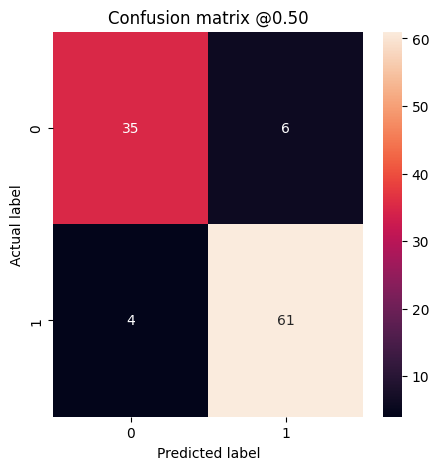

In [20]:
validation_predictions = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions)

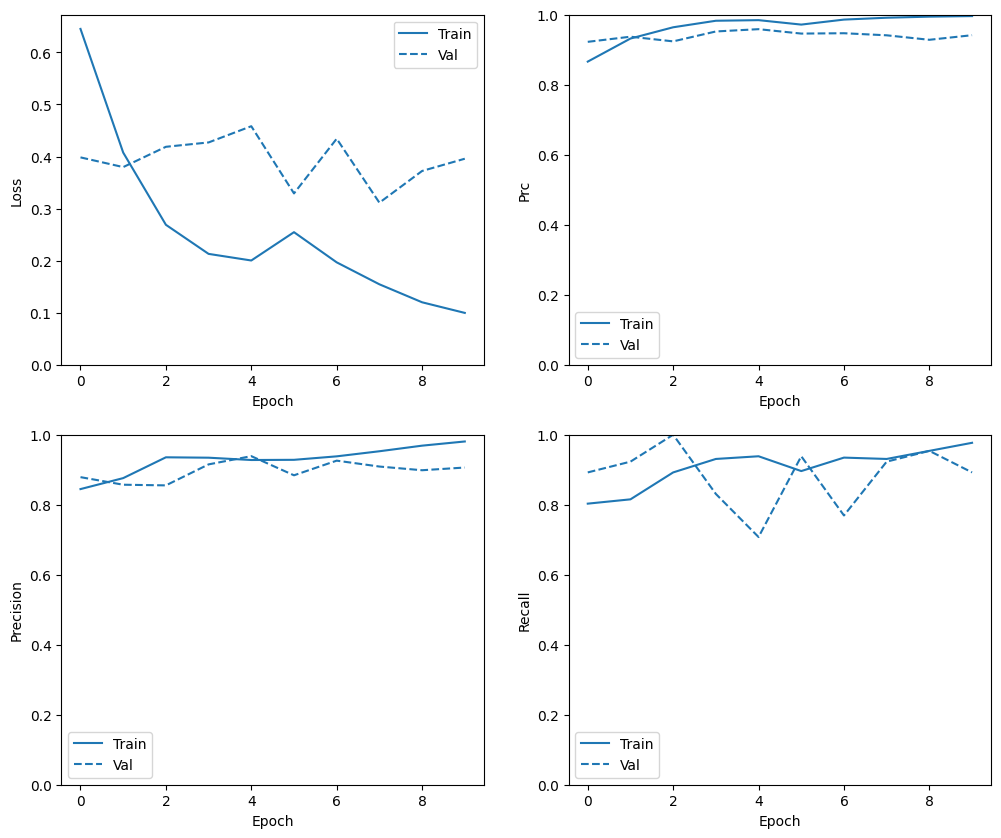

In [21]:
plot_metrics(history3)

# VGG16 MODEL

In [22]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.GlobalMaxPooling2D(),
                              tf.keras.layers.Dense(4096, activation = 'relu'),
                              tf.keras.layers.Dropout(rate=0.5),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics=metrics)

In [23]:
history4 = model.fit(train_generator,epochs = 20, validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.7117 - auc: 0.7736 - fn: 55.1136 - fp: 43.0682 - loss: 0.7062 - prc: 0.8340 - precision: 0.7789 - recall: 0.7374 - tn: 84.7727 - tp: 145.6591 - val_accuracy: 0.7264 - val_auc: 0.8227 - val_fn: 21.0000 - val_fp: 8.0000 - val_loss: 0.5665 - val_prc: 0.8542 - val_precision: 0.8462 - val_recall: 0.6769 - val_tn: 33.0000 - val_tp: 44.0000
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.7338 - auc: 0.8065 - fn: 32.1591 - fp: 22.8864 - loss: 0.5493 - prc: 0.8718 - precision: 0.8373 - recall: 0.7338 - tn: 62.3864 - tp: 105.9773 - val_accuracy: 0.7547 - val_auc: 0.8610 - val_fn: 11.0000 - val_fp: 15.0000 - val_loss: 0.4721 - val_prc: 0.8782 - val_precision: 0.7826 - val_recall: 0.8308 - val_tn: 26.0000 - val_tp: 54.0000
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.8301 - auc: 0.9119 - fn: 24.0682 - fp: 15.0455 - loss: 0.4099 - prc: 0.9471 - precision: 0.8936 - recall: 0.8354 - tn: 67.1818 - tp:

In [24]:
validation_results = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results):
  print(name, ': ', value)

loss :  0.48721110820770264
compile_metrics :  61.0


11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Non-tumor detected (True Negatives):  30
Non-tumor incorrectly detected (False Positives):  11
Tumor missed (False Negatives):  2
Tumor detected (True Positives):  63
Total case:  65


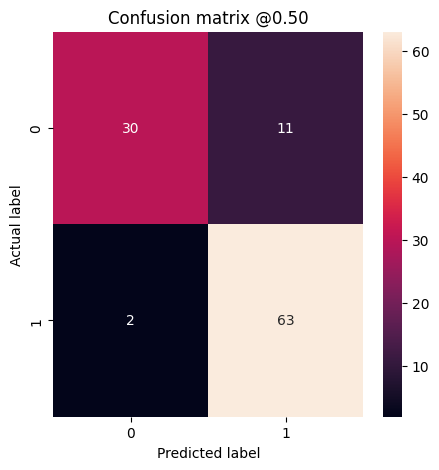

In [25]:
validation_predictions = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions)

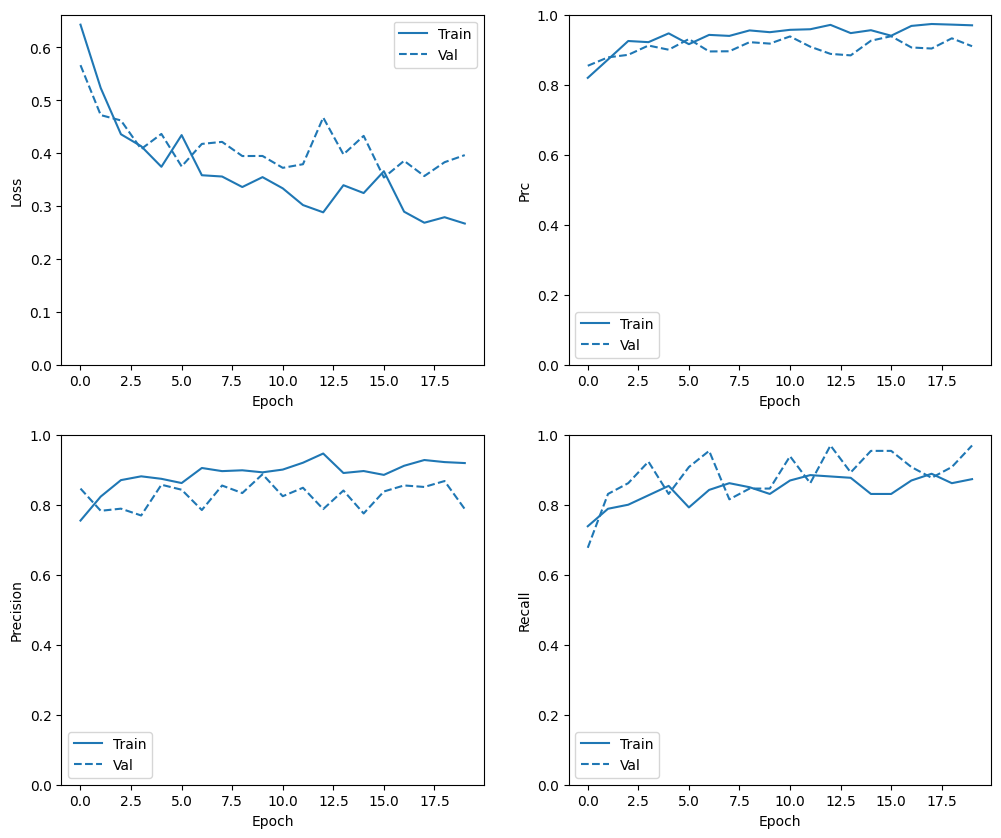

In [26]:
plot_metrics(history4)

# OVERALL RESULTS

In [27]:
res = [["Simple CNN", ],
       ["InceptionResNetV2", ],
       ["VGG16", ]]
histories = [history1,history3,history4]

for i,hist in enumerate(histories):
    
    hist_li = list(hist.history.values())
    
    acc = hist_li[15][0]
    precision = hist_li[16][0]
    recall = hist_li[17][0]
    max_auc = hist_li[18][0]
    
    mean_acc = np.mean(hist_li[15])
    mean_precision = np.mean(hist_li[16])
    mean_recall = np.mean(hist_li[17])
    mean_auc = np.mean(hist_li[18])
    
    
    for j in range(len(hist_li[16])):
        if hist_li[18][j] > max_auc: # finding epoch with maximum AUC achieved
            
            acc = hist_li[15][j]
            precision = hist_li[16][j]
            recall = hist_li[17][j]
            max_auc = hist_li[18][j]
        
    
    res[i] += [precision,recall, max_auc, acc,mean_precision, mean_recall,mean_auc,mean_acc]
    
df = pd.DataFrame(res, columns = ["Model Name", f"Precision (with Max AUC)","Recall (with Max AUC)"," Max AUC", "Accuracy",
                                 "Mean Precision", "Mean Recall","Mean AUC", "Mean Accuracy"])

df

,Model Name,Precision (with Max AUC),Recall (with Max AUC),Max AUC,Accuracy,Mean Precision,Mean Recall,Mean AUC,Mean Accuracy
0,Simple CNN,0.852941,0.892308,31.0,0.862290,0.786624,0.853846,25.70,0.857436
1,InceptionResNetV2,0.938776,0.707692,38.0,0.958726,0.896910,0.883077,34.20,0.939880
2,VGG16,0.887097,0.846154,34.0,0.917462,0.826075,0.886154,28.65,0.906274
